In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv3D, Activation, Dense, GlobalAveragePooling3D, MaxPooling3D, BatchNormalization
from tensorflow.keras.models import Sequential
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.callbacks import History

In [ ]:
path=''
filenames = '99999974_left','99999974_right','99999975_left','99999975_right'

In [ ]:
x=[]; y=[]
sample_length = 30 # equates for 1/2 sec
n_samples = 300 # samples to be extracted per video
new_size = (60,50)
for file in filenames:
    # Get RGB data from mp4 video
    cap = cv2.VideoCapture(path+file+'_hand.mp4')
    frame_width=int(cap.get(3))
    frame_height=int(cap.get(4))
    rgb_data = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            if 'right' in file:
                frame = cv2.flip(frame,1)
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            rgb_data.append(cv2.resize(frame, new_size))
        else:
            break
    cap.release()
    rgb_data=np.array(rgb_data)
    print(rgb_data.shape)
    # Get labels from csv
    df = pd.read_csv(path+file+'.csv')
    df = np.array(df)[:-1]
    # Get training data by splitting the data randomly
    # sampling without replacement
    samples_idx = np.random.choice(np.arange(rgb_data.shape[0]-sample_length),size=(n_samples),replace=False) 
    for sample in samples_idx:
        x.append(rgb_data[sample:sample+sample_length])
        y.append(df[sample:sample+sample_length])
x = np.array(x)
y = np.array(y)
x.shape, y.shape

(359, 50, 60)
(359, 50, 60)
(359, 50, 60)
(359, 50, 60)


((1200, 30, 50, 60), (1200, 30, 9))

### Split the data

In [ ]:
y.shape

(1200, 30, 9)

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(np.expand_dims(x,axis=-1),y,test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((960, 30, 50, 60, 1), (960, 30, 9), (240, 30, 50, 60, 1), (240, 30, 9))

In [ ]:
def min_max_norm(x):
    xmin = np.min(x)
    xmax = np.max(x)
    return (x-xmin)/(xmax-xmin)

In [ ]:
def binarize_open_close(batch):
  binarized = []
  for sample in batch:
    sample_binarized=[]
    for item in sample:
      if item =='close':
        sample_binarized.append(0)
      if item =='open':
        sample_binarized.append(1)
    binarized.append(sample_binarized)
  return np.array(binarized)

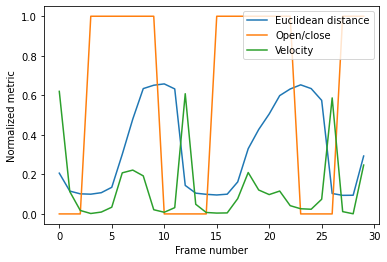

In [ ]:
plt.plot(min_max_norm(y_train[:,:,6])[0])
plt.plot(binarize_open_close(y_train[:,:,7])[0])
plt.plot(min_max_norm(y_train[:,:,8])[0])
plt.xlabel('Frame number')
plt.ylabel('Normalized metric')
plt.legend(['Euclidean distance', 'Open/close', 'Velocity'], loc='upper right')
plt.savefig('sample_label_cnn.pdf', dpi=300)

In [ ]:
model = Sequential([
    Conv3D(8, kernel_size=(7,9,11), input_shape = (sample_length,50,60,1)),
    BatchNormalization(),
    Activation('relu'),
    Conv3D(16, kernel_size=(7,9,11)),
    BatchNormalization(),
    Activation('relu'),
    #MaxPooling3D(pool_size=(2)),
    
    Conv3D(32, kernel_size=(5,7,9)),
    BatchNormalization(),
    Activation('relu'),
    Conv3D(64, kernel_size=(5,7,9)),
    BatchNormalization(),
    Activation('relu'),
    #MaxPooling3D(pool_size=(2)),
    
    Conv3D(128, kernel_size=(3,5,7)),
    BatchNormalization(),
    Activation('relu'),
    Conv3D(256, kernel_size=(3,5,7)),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling3D(),
    BatchNormalization(),
    
    Dense(sample_length),
    BatchNormalization(),
    Activation('sigmoid'),
])
model.compile(optimizer='adamax', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 24, 42, 50, 8)     5552      
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 42, 50, 8)     32        
_________________________________________________________________
activation (Activation)      (None, 24, 42, 50, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 18, 34, 40, 16)    88720     
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 34, 40, 16)    64        
_________________________________________________________________
activation_1 (Activation)    (None, 18, 34, 40, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 14, 28, 32, 32)    1

In [ ]:
history = History()
model.fit(x_train, min_max_norm(y_train[:,:,8]).astype('float'),epochs=50, 
          batch_size=8,validation_data=(x_test,min_max_norm(y_test[:,:,8]).astype('float')),callbacks=[history])
#model.fit(x_train, binarize_open_close(y_train[:,:,7]).astype('float'),epochs=50, 
#          batch_size=8,validation_data=(x_test,binarize_open_close(y_test[:,:,7]).astype('float')),callbacks=[history])

Epoch 1/50
120/120 [==============================] - 43s 305ms/step - loss: 0.1739 - val_loss: 0.1146
Epoch 2/50
120/120 [==============================] - 36s 297ms/step - loss: 0.1588 - val_loss: 0.1779
Epoch 3/50
120/120 [==============================] - 36s 298ms/step - loss: 0.1456 - val_loss: 0.1789
Epoch 4/50
120/120 [==============================] - 36s 299ms/step - loss: 0.1349 - val_loss: 0.2443
Epoch 5/50
120/120 [==============================] - 35s 291ms/step - loss: 0.1242 - val_loss: 0.0558
Epoch 6/50
120/120 [==============================] - 36s 299ms/step - loss: 0.1140 - val_loss: 0.0660
Epoch 7/50
120/120 [==============================] - 36s 298ms/step - loss: 0.1028 - val_loss: 0.0712
Epoch 8/50
120/120 [==============================] - 36s 299ms/step - loss: 0.0930 - val_loss: 0.1516
Epoch 9/50
120/120 [==============================] - 36s 298ms/step - loss: 0.0828 - val_loss: 0.0579
Epoch 10/50
120/120 [==============================] - 35s 292ms/step - l

In [ ]:
model.save('vel_finger_30f.h5')

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

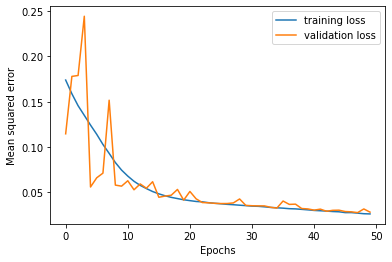

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.savefig('vel_loss_epochs.pdf', dpi=300)

In [ ]:
preds=model.predict(x_test)

In [ ]:
residuals=[]
for i in range(x_test.shape[0]):
  residuals.append(model.evaluate(np.expand_dims(x_test[i],axis=0), np.expand_dims(min_max_norm(y_test[:,:,8].astype('float'))[i],axis=0),verbose=0))
  #residuals.append(model.evaluate(np.expand_dims(x_test[i],axis=0), np.expand_dims(binarize_open_close(y_test[:,:,7])[i],axis=0),verbose=0))
np.array(residuals).shape

(240,)

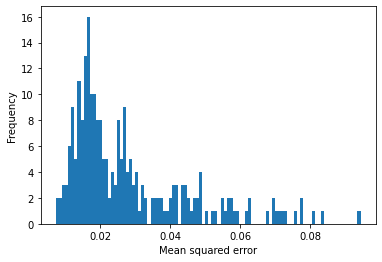

In [ ]:
plt.hist(residuals,bins=100);
plt.xlabel('Mean squared error')
plt.ylabel('Frequency')
plt.savefig('vel_mse_hist.pdf', dpi=300)

0.021590692922472954

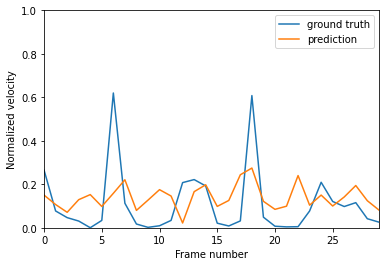

In [ ]:
idx=23
plt.plot(min_max_norm(y_test[:,:,8])[idx])
plt.plot(preds[idx])
plt.xlabel('Frame number')
plt.ylabel('Normalized velocity')
plt.ylim([0,1])
plt.xlim([0,29])
#plt.hlines(0.5,0,30,colors='red', linestyles='dashed')
plt.legend(['ground truth', 'prediction'], loc='upper right')
plt.savefig('vel_median_pred.pdf', dpi=300)
residuals[idx]

In [ ]:
np.argmin(residuals), np.argmax(residuals), np.argsort(residuals)[len(residuals)//2]

(92, 3, 23)